In [1]:
import warnings
warnings.filterwarnings("ignore")
import glob
import os
import pandas as pd
import numpy as np
from __future__ import division
import matplotlib.pyplot as plt
import seaborn as sns
import merino.build_summary.expected_sensitivities as sense
import cmapPy.pandasGEXpress.parse as pe
import cmapPy.pandasGEXpress.subset_gctoo as sub
import cmapPy.pandasGEXpress.write_gctx as wgx
sns.set(font_scale=1.5)
sns.set_style("whitegrid")

BASE_PATH = os.path.expanduser('~/data/pfc')

In [2]:
def plot_ecdf(values, ax, **kwargs):
    # equal weight for each observation, summing to 1
    weights = np.ones_like(values)/float(len(values))
    bins = sorted(values) + [np.inf]
    sns.distplot(values,
                 hist_kws={"cumulative": True,
                           "weights": weights,
                           "histtype": "step",
                           "alpha": 1,
                           "linewidth": 2},
                 bins=bins,
                 kde=False,
                 ax=ax,
                 **kwargs)
    
def fraction_recalled(df, threshold):
    return np.sum(df["median_recall_rank"] <= threshold) / len(df)

## Replicate Recall

In [3]:
proj_dir = os.path.join(BASE_PATH,'input/card/')
input_type = 'ZSPC'

In [4]:
def mk_ds_list(proj_dir, input_type):
    filepaths = []
    group_ids = []
    
    search = proj_dir + '*/*{}.gct'.format(input_type)
    print proj_dir
    print search
    for path in glob.glob(search):
        new_path = os.path.join('input/card',os.path.basename(os.path.dirname(path)), os.path.basename(path)) 
        filepaths.append(new_path)
        group_ids.append(os.path.basename(os.path.dirname(path)).rsplit('_', 2)[0])
        
    ds_list = pd.DataFrame({'group_id': group_ids, 'file_path': filepaths})
    ds_list['file_path'] = ['/' + x for x in ds_list['file_path']]
    return ds_list

In [5]:
if not os.path.isdir("output"):
    os.mkdir("output")

if not os.path.isdir("output/recall"):
    os.mkdir("output/recall")

In [6]:
ds_list = mk_ds_list(proj_dir, input_type)
ds_list.to_csv('output/ds_list.txt', sep='\t', index=False)

/home/jupyter-jasiedu/data/pfc/input/card/
/home/jupyter-jasiedu/data/pfc/input/card/*/*ZSPC.gct


In [7]:
%%capture sig_recall_output
! udocker run --rm \
    -v ~/data/pfc/input:/input \
    -v ~/data/pfc/vdb:/cmap/data/vdb \
    -v $PWD/output:/output \
    cmap/sig_recall_tool \
    --ds_list /output/ds_list.txt \
    --metric spearman \
    --sample_field pert_well \
    --out /output/recall \
    --create_subdir 0

In [8]:
recall_result_paths = glob.glob(os.path.join("output/recall", "*", "recall_report_sets.txt"))
print recall_result_paths
recall_df = pd.concat([pd.read_csv(path, sep="\t", na_values="-666") for path in recall_result_paths])
recall_df["weave_prefix"] = recall_df["recall_group"].str.split(":").str[0]

['output/recall/PREP017/recall_report_sets.txt', 'output/recall/PREP020/recall_report_sets.txt', 'output/recall/PREP018/recall_report_sets.txt', 'output/recall/PREP014/recall_report_sets.txt', 'output/recall/PREP019/recall_report_sets.txt', 'output/recall/PASG003_CS5_120H/recall_report_sets.txt', 'output/recall/PREP015/recall_report_sets.txt', 'output/recall/PREP016/recall_report_sets.txt']


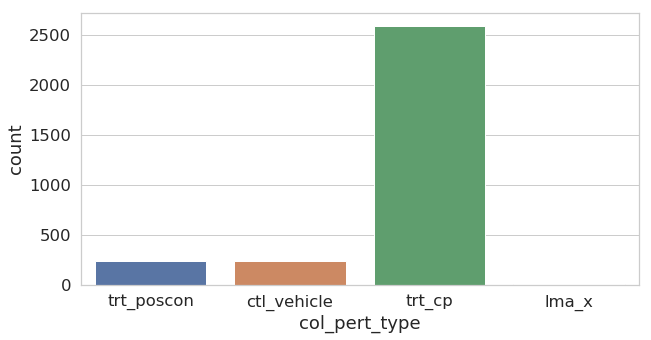

In [9]:
f, ax = plt.subplots(1, 1, figsize=(10,5))
sns.countplot(x="col_pert_type", data=recall_df)
plt.show()

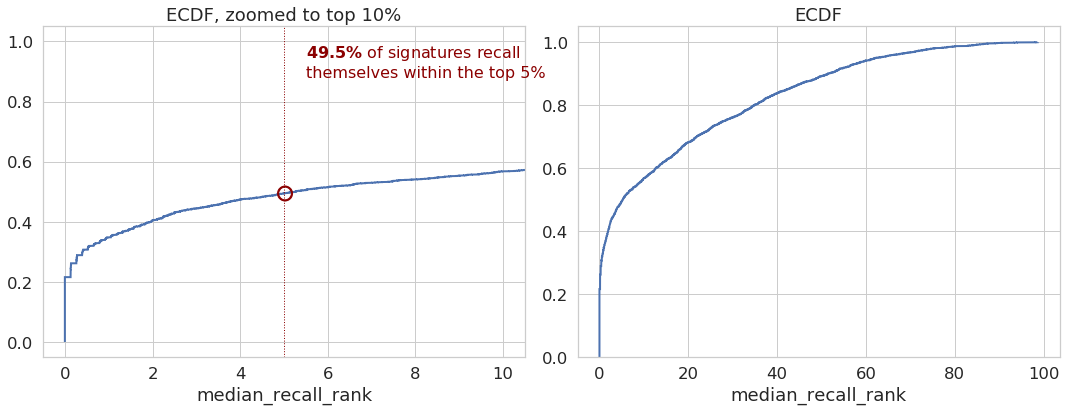

In [10]:
f, ax = plt.subplots(1, 2, figsize=(15,6)) 

plot_ecdf(recall_df["median_recall_rank"], ax[0])
ax[0].set_xlim(-0.5, 10.5)
ax[0].set_ylim(-0.05, 1.05)
ax[0].set_title("ECDF, zoomed to top 10%")

recall_top5_pct = np.sum(recall_df["median_recall_rank"] <= 5) / len(recall_df) * 100
ax[0].axvline(5, linestyle="dotted", linewidth=1, color="darkred")
ax[0].text(5.5, 1,
           (r"$\bf{0:.1f}\%$".format(recall_top5_pct) +
            " of signatures recall\nthemselves within the top 5%"),
           verticalalignment="top",
           fontsize=16,
           color="darkred")
ax[0].plot(5, recall_top5_pct/100, marker=r'$\bigcirc$', markersize=16, color="darkred")

plot_ecdf(recall_df["median_recall_rank"], ax[1])
ax[1].set_title("ECDF")

f.tight_layout(rect=(0,.03,1,1))
plt.show()

In [11]:
global_recall_result_df = pd.DataFrame()
global_recall_result_df.loc["whole benchmark dataset", "fraction of signatures recalled at 5%"] = fraction_recalled(recall_df, 5)
global_recall_result_df

,fraction of signatures recalled at 5%
whole benchmark dataset,0.494613


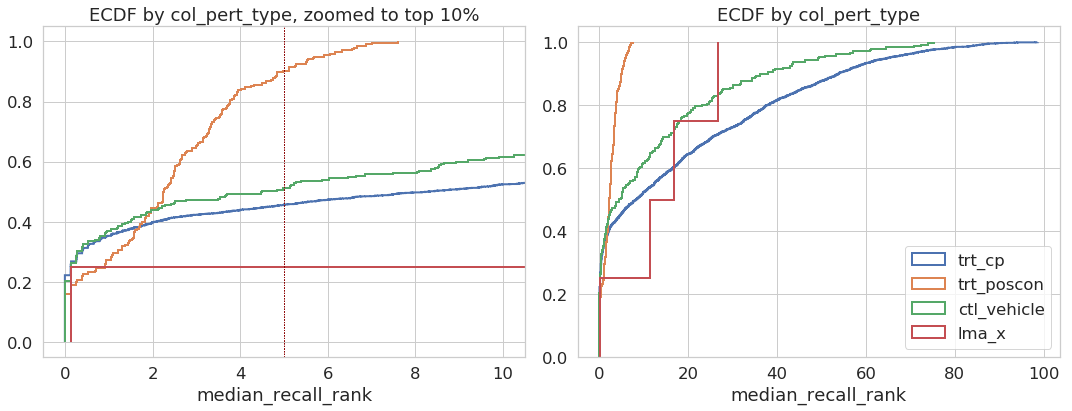

In [12]:
f, ax = plt.subplots(1, 2, figsize=(15,6))
field = "col_pert_type"
field_values = recall_df[field].value_counts().loc[lambda count: count > 1].index.tolist()
n_field = len(field_values)
#color_pal = sns.color_palette("tab10", n_field)

for ii, value in enumerate(field_values):
    cur_df = recall_df[recall_df[field] == value]
    plot_ecdf(cur_df["median_recall_rank"], ax[0], label=str(value))
    ax[0].set_xlim(-0.5, 10.5)
    ax[0].set_ylim(-0.05, 1.05)
    ax[0].set_title("ECDF by {}, zoomed to top 10%".format(field))
    ax[0].axvline(5, linestyle="dotted", linewidth=1, color="darkred")

    plot_ecdf(cur_df["median_recall_rank"], ax[1], label=str(value))
    ax[1].set_title("ECDF by {}".format(field))

f.tight_layout(rect=(0,.03,1,1))
plt.legend(loc="lower right")
plt.show()

In [13]:
type_recall_result_df = pd.DataFrame()
for pert_type in ["trt_cp", "trt_poscon", "ctl_vehicle"]:
    type_recall_result_df.loc[pert_type, "fraction of signatures recalled at 5%"] = fraction_recalled(recall_df[recall_df["col_pert_type"] == pert_type], 5)
type_recall_result_df

,fraction of signatures recalled at 5%
trt_cp,0.456337
trt_poscon,0.902542
ctl_vehicle,0.510638


In [14]:
dose_counts = recall_df.groupby('col_pert_idose')['recall_group'].nunique()
dose_df = recall_df[recall_df['col_pert_idose'].isin(dose_counts[dose_counts > 10].index.tolist())]


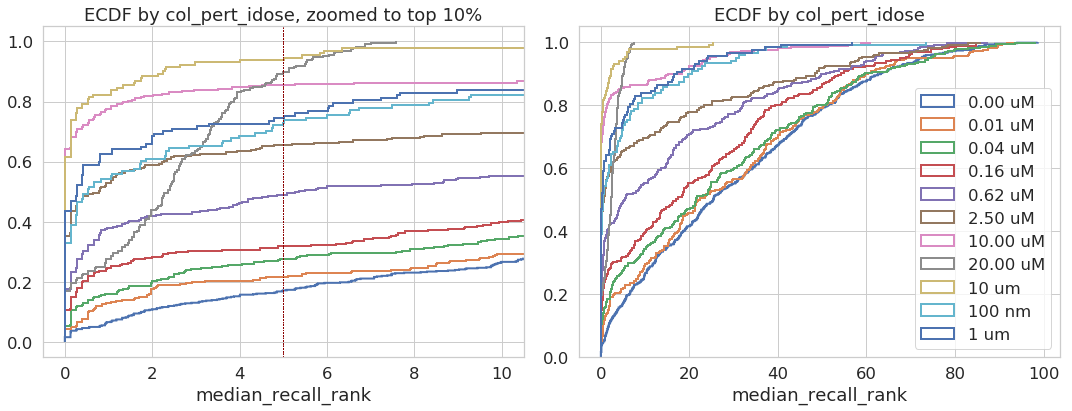

In [15]:
f, ax = plt.subplots(1, 2, figsize=(15,6))
field = "col_pert_idose"
field_values = dose_df[field].value_counts().loc[lambda count: count > 1].index.tolist()
n_field = len(field_values)

for ii, value in enumerate(field_values):
    cur_df = dose_df[dose_df[field] == value]
    plot_ecdf(cur_df["median_recall_rank"], ax[0], label=str(value))
    ax[0].set_xlim(-0.5, 10.5)
    ax[0].set_ylim(-0.05, 1.05)
    ax[0].set_title("ECDF by {}, zoomed to top 10%".format(field))
    ax[0].axvline(5, linestyle="dotted", linewidth=1, color="darkred")

    plot_ecdf(cur_df["median_recall_rank"], ax[1], label=str(value))
    ax[1].set_title("ECDF by {}".format(field))

f.tight_layout(rect=(0,.03,1,1))
plt.legend(loc="lower right")
plt.show()

In [16]:
dose_recall_result_df = pd.DataFrame()
for pert_idose in ["20.00 uM", "10.00 uM", "2.50 uM", "0.62 uM", "0.16 uM", "0.04 uM", "0.01 uM", "0.00 uM"]:
    dose_recall_result_df.loc[pert_idose, "fraction of signatures recalled at 5%"] = fraction_recalled(dose_df[dose_df["col_pert_idose"] == pert_idose], 5)
dose_recall_result_df

,fraction of signatures recalled at 5%
20.00 uM,0.897321
10.00 uM,0.854839
2.50 uM,0.654762
0.62 uM,0.490119
0.16 uM,0.318008
0.04 uM,0.275362
0.01 uM,0.215054
0.00 uM,0.171735


## Expected Sensitivities

In [17]:
data = pe.parse(os.path.join(BASE_PATH,'input/pasg_build/PASG003_LEVEL5_MODZ.LFCPC.CB_n383x489.gctx'))
sig = pd.read_table(os.path.join(BASE_PATH,'input/pasg_build/PASG003_MODZ.LFCPC.CB_sig_metrics.txt'), index_col='sig_id')

In [18]:
if not os.path.isdir('output/sensitivities/'):
    os.makedirs('output/sensitivities/')

In [19]:
sense.wtks(gct=data, metadata=sig, outfolder='output/sensitivities/', gmt_path=os.path.join(BASE_PATH,"vdb/PRISM/sensitivity_files/full_sensitivities.gmt"))

In [20]:
expected_sensitivites_results = pd.read_table('output/sensitivities/expected_sensitivity_ranks.txt', index_col='det_plate')

In [21]:
expected_sensitivites_results

,AS-605240_1 um,AS-605240_10 um,AS-605240_100 nm,AZ-628_1 um,AZ-628_10 um,AZ-628_100 nm,PHA-793887_1 um,PHA-793887_10 um,PHA-793887_100 nm,afatinib_1 um,...,tozasertib_100 nm,vandetanib_1 um,vandetanib_10 um,vandetanib_100 nm,vemurafenib_1 um,vemurafenib_10 um,vemurafenib_100 nm,vorinostat_1 um,vorinostat_10 um,vorinostat_100 nm
det_plate,,,,,,,,,,,,,,,,,,,,,
PASG003_CS5,354,144,255,2,33,13,18,150,28,4,...,9,11,16,7,1,6,36,5,19,339


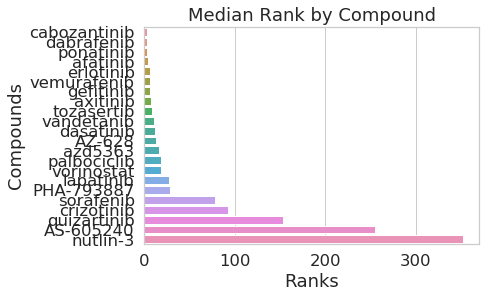

In [22]:
cps = pd.Series([x.split('_')[0] for x in expected_sensitivites_results.columns]).unique()
median_ranks = []
for cp in cps:
    cp_median_rank = expected_sensitivites_results[[x for x in expected_sensitivites_results.columns if x.startswith(cp)]].median(axis=1).values[0]
    median_ranks.append(cp_median_rank)
    
    
data = pd.concat([pd.Series(cps).rename('Compounds'), pd.Series(median_ranks).rename('Ranks')], axis=1)
sns.barplot(x='Ranks', y='Compounds', data=data.sort_values('Ranks'))
plt.title('Median Rank by Compound')
plt.show()

In [23]:
expected_sensitivites_results[[x for x in expected_sensitivites_results.columns if 'nutlin' in x]]

,nutlin-3_1 um,nutlin-3_10 um,nutlin-3_100 nm
det_plate,,,
PASG003_CS5,352,1,361


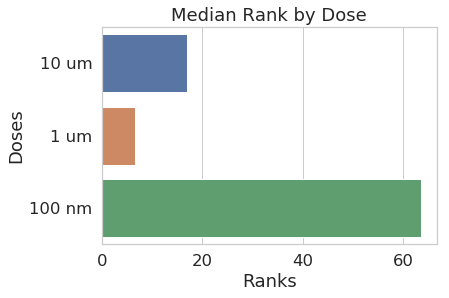

In [24]:
doses = pd.Series([x.split('_')[1] for x in expected_sensitivites_results.columns]).unique()
median_ranks = []
for ds in doses:
    ds_median_rank = expected_sensitivites_results[[x for x in expected_sensitivites_results.columns if ds in x]].median(axis=1).values[0]
    median_ranks.append(ds_median_rank)
    
    
data = pd.concat([pd.Series(doses).rename('Doses'), pd.Series(median_ranks).rename('Ranks')], axis=1)
sns.barplot(x='Ranks', y='Doses', data=data.sort_values('Ranks'), order=['10 um', '1 um', '100 nm'])
plt.title('Median Rank by Dose')
plt.show()

In [25]:
if not os.path.isdir('output/introspect/'):
    os.makedirs('output/introspect/')

## PCL Analysis

In [26]:
#%%capture sig_recall_output
! udocker run --rm \
    -v ~/data/pfc/input:/input \
    -v ~/data/pfc/vdb:/cmap/data/vdb \
    -v $PWD/output:/output \
    cmap/sig_introspect_tool \
    --sig_score /input/pasg_build/PASG003_LEVEL5_MODZ.LFCPC.CB_n383x489.gctx \
    --sig_col_meta /input/pasg_build/PASG003_MODZ.LFCPC.CB_sig_metrics.txt \
    --metric wtcs \
    --gset_size 25 \
    --es_tail down \
    --out /output/introspect \
    --create_subdir 0

 
 ****************************************************************************** 
 *                                                                            * 
 *               STARTING c4cc8473-40a5-32b1-b2ba-32761db3bc95                * 
 *                                                                            * 
 ****************************************************************************** 
 executing: rum
	  properly without it.
	  properly without it.
Setting MCR_CACHE_ROOT to /tmp/mcr_cache_root
Running
 > nohup  /cmap/tools/sig_tools/run_sig_introspect_tool.sh /cmap/tools/sig_tools/mcr/versions/v84 --sig_score /input/pasg_build/PASG003_LEVEL5_MODZ.LFCPC.CB_n383x489.gctx --sig_col_meta /input/pasg_build/PASG003_MODZ.LFCPC.CB_sig_metrics.txt --metric wtcs --gset_size 25 --es_tail down --out /output/introspect --create_subdir 0 
nohup: ignoring input and appending output to 'nohup.out'
Tool exited with code 0
sig_introspect_tool:
Script executing [PID=14315]
Press ^C to q

rum sig_introspect_tool --out /cmap/obelix/pod/custom/CORE/sas --sig_score /cmap/obelix/pod/custom/CORE/elwork/reprocess/build/CORE_LEVEL5_MODZ.ZSPC.COMBAT_n19469x100.gctx --sig_col_meta /cmap/obelix/pod/custom/CORE/elwork/reprocess/build/CORE_sig_metrics_MODZ.ZSPC.COMBAT.txt --gset_size 25 --metric wtcs --es_tail down

In [27]:
# split ps gctx by dose
# one entry per compound
# two metadata files, one for column and one for row

In [28]:
if not os.path.isdir('output/introspect/for_pcl'):
    os.makedirs('output/introspect/for_pcl')
intro = pe.parse('output/introspect/ps_n383x383.gctx')
intro.col_metadata_df['group_id'] = intro.col_metadata_df['group_by']
intro.row_metadata_df['group_id'] = intro.row_metadata_df['group_by']
cp_dex = intro.col_metadata_df[intro.col_metadata_df['pert_type'] == 'trt_cp'].index
cp_intro = sub.subset_gctoo(intro, rid=cp_dex.tolist(), cid=cp_dex.tolist())
cp_intro.col_metadata_df.to_csv('output/introspect/for_pcl/col_meta_n{}.txt'.format(cp_intro.col_metadata_df.shape[0]))
cp_intro.row_metadata_df.to_csv('output/introspect/for_pcl/row_meta_n{}.txt'.format(cp_intro.row_metadata_df.shape[0]))
for dose in cp_intro.col_metadata_df['pert_idose'].unique():
    print dose
    dex = cp_intro.col_metadata_df[cp_intro.col_metadata_df['pert_idose'] == dose].index
    temp_dose = sub.subset_gctoo(cp_intro, rid=dex.tolist(), cid=dex.tolist())
    print temp_dose.data_df.shape
    wgx.write(temp_dose, 'output/introspect/for_pcl/ps_{}_n{}x{}.gctx'.format(dose, temp_dose.data_df.shape[1], temp_dose.data_df.shape[0]))


10 um
(118, 118)
1 um
(117, 117)
100 nm
(118, 118)


In [29]:
if not os.path.isdir('output/pcleval'):
    os.makedirs('output/pcleval')

In [30]:
%%capture sig_recall_output
! udocker run --rm \
    -v ~/data/pfc/input:/input \
    -v ~/data/pfc/vdb:/cmap/data/vdb \
    -v $PWD/output:/output \
    cmap/sig_pcleval_tool \
    --inpath /output/introspect/for_pcl/ \
    --boxplot_label_field group_id \
    --cluster_method hclust \
    --match_field pert_id \
    --heatmap_label_field pert_iname \
    --pcl /input/moa_groups_minsz3_n358.gmt \
    --out /output/pcleval \
    --create_subdir 0

In [31]:
master_pcl_table = pd.DataFrame()
for dose in cp_intro.col_metadata_df['pert_idose'].unique():
    temp = pd.read_table('output/pcleval/{}/pcl_connectivity.txt'.format(dose), index_col='group_id')
    master_pcl_table = master_pcl_table.append(temp)

In [32]:
master_pcl_table = master_pcl_table[master_pcl_table['group_size'] > 2]

In [33]:
master_pcl_table.head()

,group_name,pert_id,pert_iname,cell_id,pert_type,group_size,median_rankpt,iqr_rankpt,q75_rankpt,q25_rankpt,noutlier,outlier
group_id,,,,,,,,,,,,
tubulin polymerization inhibitor,tubulin polymerization inhibitor,BRD-K02407574|BRD-K12539581|BRD-K91623615,parbendazole|nocodazole|ABT-751,10 um,trt_cp,3,99.1514,0.244774,99.2004,98.9556,0,NaN
EGFR inhibitor,EGFR inhibitor,BRD-K70401845|BRD-K64052750|BRD-K66175015|BRD-...,erlotinib|gefitinib|afatinib|lapatinib,10 um,trt_cp,4,98.3029,0.261093,98.5640,98.3029,0,NaN
MEK inhibitor,MEK inhibitor,BRD-K57080016|BRD-K12343256|BRD-K49865102,selumetinib|trametinib|PD-0325901,10 um,trt_cp,3,98.1070,0.538513,98.5477,98.0091,0,NaN
RAF inhibitor,RAF inhibitor,BRD-K56343971|BRD-K09951645|BRD-K05804044,vemurafenib|dabrafenib|AZ-628,10 um,trt_cp,3,97.5196,0.587463,97.8133,97.2258,0,NaN
HSP inhibitor,HSP inhibitor,BRD-K41213548|BRD-A03506276|BRD-K41859756,kw-2478|xl888|NVP-AUY922,10 um,trt_cp,3,83.6241,11.792400,85.2590,73.4667,0,NaN


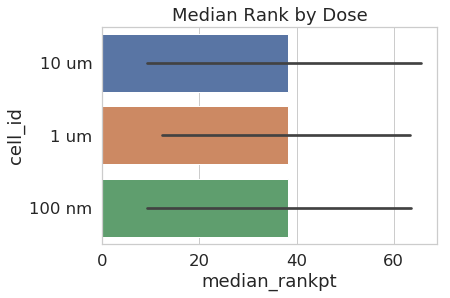

In [34]:
sns.barplot(x='median_rankpt', y='cell_id', data=master_pcl_table, order=['10 um', '1 um', '100 nm'])
plt.title('Median Rank by Dose')
plt.show()

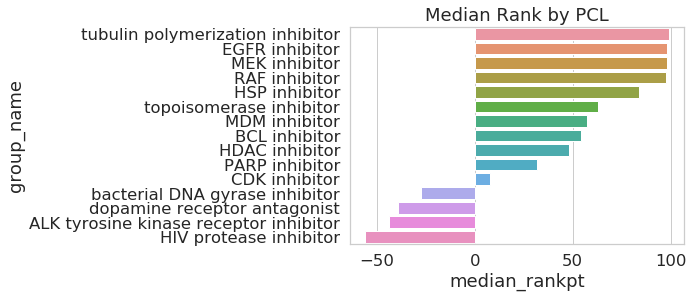

In [35]:
sns.barplot(x='median_rankpt', y='group_name', data=master_pcl_table.sort_values(['median_rankpt', 'group_name'], ascending=False))
plt.title('Median Rank by PCL')
plt.show()